In [10]:
import h5py
import numpy as np
from scipy.optimize import curve_fit, root_scalar
from scipy.constants import h, k, hbar
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm

In [11]:
data_file_path = '/home/kth-user/Documents/data/'
folder_name = 'LKIPA_3/'
h5_filename = 'LKIPA_3.hdf5'
f = h5py.File(data_file_path + folder_name + h5_filename)

In [12]:
# sample = "LKIPA_2_07-05"
# run_list = ["2025-08-27_13_42_02", \
#             "2025-08-27_13_50_45", \
#             "2025-08-27_13_47_19", \
#             "2025-08-27_13_52_56", \
#             "2025-08-27_13_55_06", \
#             "2025-08-27_13_57_02", \
#             "2025-08-27_14_00_05", \
#             "2025-08-27_14_02_04", \
#             "2025-08-27_14_04_03", \
#             "2025-08-27_14_06_04", \
#             "2025-08-27_14_08_43", \
#             "2025-08-27_14_11_07", \
#             "2025-08-27_14_13_31", \
#             "2025-08-27_14_15_42"]

sample = "LKIPA_3_17-09"
run_list = ['2025-09-23_14_32_48',
            '2025-09-23_14_35_16',
            '2025-09-23_14_37_43',
            '2025-09-23_14_40_06',
            '2025-09-23_14_43_01',
            '2025-09-23_14_45_24',
            '2025-09-23_14_47_50',
            '2025-09-23_14_50_25',
            '2025-09-23_14_52_59',
            '2025-09-23_14_55_23',
            '2025-09-23_14_57_51',
            '2025-09-23_15_00_29',
            '2025-09-23_15_02_56',
            '2025-09-23_15_05_25',
            '2025-09-23_15_07_52',
            '2025-09-23_15_10_57']

[3.11028253e+10 9.96016327e+00]
[3.11027832e+10 1.10451920e-21 8.83070648e+00]
T_c_TTF = 9.960163271043571, T_c_MB = 8.830706480021204, Delta_0 = 1.1045192e-21
2.55420065e-22
9.059297824131496


/tmp/ipykernel_272447/1384531093.py:134: OptimizeWarning: Covariance of the parameters could not be estimated
  omega_mb_popt, omega_mb_pcov = curve_fit(omega_mb_model, T_arr, 2*np.pi*f0_arr, p0 = omega_mb_init_guess)


Text(0.05, 0.35, 'T_c_TTF=9.96 K')

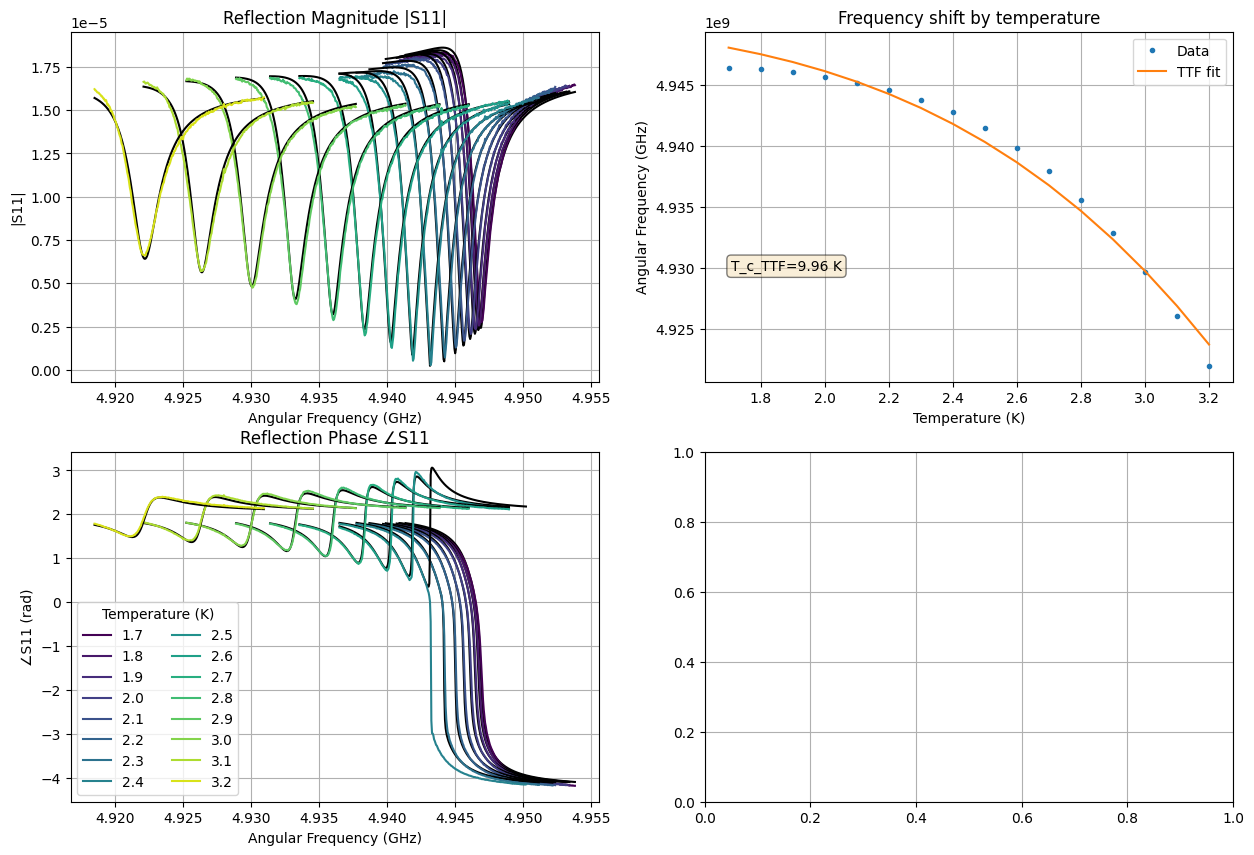

In [15]:
### Fitting low power measurements with linear model

### Model for a linear resonance peak.
def correct_delay(S_11_data, meas_freq, delay):
    return S_11_data * np.exp(2*np.pi* 1j * meas_freq * delay)

def linear_model_form(freq_array, freq0, k0, ke, q, a, b, phi):
    delta = freq_array - freq0
    num = (k0 - ke)/2 + 1j * delta + 1j*q
    den = (k0 + ke)/2 + 1j * delta
    S_11 = ((a + b*freq_array)) * np.exp(1j * phi) * ( num / den - D)
    return S_11

### Splits up the linear model in real and imaginary parts for fitting.
def linear_fitting_form(freq, freq0, k0, ke, q, a, b, phi):
    S_11 = linear_model_form(freq, freq0, k0, ke, q, a, b, phi)
    return np.concatenate([np.real(S_11), np.imag(S_11)])

def guess_losses(freq, S_11):

    S_11_mag = np.abs(S_11)
    
    # Find resonance frequency (minimum in magnitude)
    min_idx = np.argmin(S_11_mag)
    f0_guess = freq[min_idx]

    # Estimate total linewidth (FWHM)
    mag_dip = S_11_mag[min_idx]
    half_max = mag_dip + (1 - mag_dip)/2  # halfway between dip and 1

    indices_below = np.where(S_11_mag < half_max)[0]
    if len(indices_below) >= 2:
        f_low = freq[indices_below[0]]
        f_high = freq[indices_below[-1]]
        kappa_total = f_high - f_low
    else:
        kappa_total = (freq[-1] - freq[0]) / 100  # fallback guess

    return f0_guess, kappa_total

T_arr = np.array([])
f0_arr = np.array([])
k0_arr = np.array([])
ke_arr = np.array([])

plt.rcParams['axes.grid'] = True
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
legend = []

cmap = cm['viridis']

for i, test_run in enumerate(run_list[:]):

    meas_num = 0

    D = 0.1 #directionality, for highly over- or undercoupled measurements this needs to be included.

    meas_num = 0

    S_11_data = f[sample][test_run][str(meas_num)]['Data'][()]
    meas_freq = f[sample][test_run][str(meas_num)]['Frequency'][()]
    temp = f[sample][test_run].attrs["T"]

    delay = 7.56e-8

    S_11_data_corr_scaled = correct_delay(S_11_data, meas_freq, delay)

    S_11_real = np.real(S_11_data_corr_scaled)
    S_11_imag = np.imag(S_11_data_corr_scaled)

    S_11_fitting = np.concatenate([S_11_real, S_11_imag])

    f0_guess, k_tot_guess = guess_losses(meas_freq, S_11_data_corr_scaled)

    init_guess = [f0_guess, 5e3, 1e4, 0, 0.45, 0, 0]

    lin_popt, lin_pcov = curve_fit(linear_fitting_form, meas_freq, S_11_fitting, p0 = init_guess)

    freq0, k0, ke, q, a, b, phi = lin_popt

    # print(f"Linear fit of measurement at T = {temp} K: \
    # f0 = {freq0}, \
    # k0 = {k0}, \
    # ke = {ke}, \
    # K_tot = {k0 + ke}, \
    # Asym(q) = {q}, \
    # Baseline(a) = {a}, \
    # Slope(b) = {b}, \
    # Phase shift = {phi}")

    f0_arr = np.append(f0_arr, freq0)
    k0_arr = np.append(k0_arr, k0)
    ke_arr = np.append(ke_arr, ke)
    T_arr = np.append(T_arr, temp)

    min_idx = np.argmin(S_11_data_corr_scaled)
    start = min_idx - 150
    stop = min_idx + 100

    fitted_data = linear_fitting_form(meas_freq, *lin_popt)
    ax[0, 0].plot(meas_freq[start:stop]/1e9, abs(linear_model_form(meas_freq, *lin_popt))[start:stop], color = "k", label='_nolegend_')
    ax[1, 0].plot(meas_freq[start:stop]/1e9, np.unwrap(np.angle(linear_model_form(meas_freq, *lin_popt)))[start:stop], color = "k", label='_nolegend_')

    color = cmap(i / len(run_list))
    ax[0, 0].plot(meas_freq[start:stop]/1e9, np.abs(S_11_data_corr_scaled)[start:stop], color = color, label='_nolegend_')
    ax[1, 0].plot(meas_freq[start:stop]/1e9, np.unwrap(np.angle(S_11_data_corr_scaled))[start:stop], color = color, label = f"{temp}")

###Two-fluid model
def lambda_ttf_model(T, T_c):
    return 1 / (1 - (T/T_c)**4)

def omega_ttf_model(T, omega0_T0, T_c):
    return omega0_T0 * np.sqrt(1 - (T/T_c)**4)

###Mattis-Bardeen model
def lambda_mb_model(T, Delta_0, T_c):
    return 1 / ( np.sqrt( np.cos(np.pi/2 * (T/T_c)**2)) * np.tanh( Delta_0 * np.sqrt( np.cos(np.pi/2 * (T/T_c)**2)) / (2*k*T)) )

def omega_mb_model(T, omega0_T0, Delta_0, T_c):
    return omega0_T0/np.sqrt(lambda_mb_model(T, Delta_0, T_c))
#     return omega0_T0 * np.sqrt( np.sqrt( np.cos(np.pi/2 * (T/T_c)**2)) * np.tanh( Delta_0 * np.sqrt( np.cos(np.pi/2 * (T/T_c)**2)) / (2*k*T)) )

def internal_losses_mb(T, omega0_T0, Delta_0, T_c):
    
    # Delta = hbar / np.pi * R_N / L_k
    return omega0_T0**2 * hbar / (np.pi * Delta_0) * (lambda_mb_model(T, Delta_0, T_c) - 1) / lambda_mb_model(T, Delta_0, T_c)


omega_ttf_init_guess = [2*np.pi*f0_arr[0], 10]
omega_ttf_popt, omega_ttf_pcov = curve_fit(omega_ttf_model, T_arr, 2*np.pi*f0_arr, p0 = omega_ttf_init_guess)
print(omega_ttf_popt)

omega_mb_init_guess = [2*np.pi*f0_arr[0], 8*10*k, 9]
omega_mb_popt, omega_mb_pcov = curve_fit(omega_mb_model, T_arr, 2*np.pi*f0_arr, p0 = omega_mb_init_guess)
print(omega_mb_popt)

omega0_T0, Delta_0, T_c = omega_mb_popt
    
def external_losses_mb(T, k_ext_0):
    return k_ext_0/lambda_mb_model(T, Delta_0, T_c)

ext_loss_guess = [10e6]
ext_loss_popt, ext_loss_pcov = curve_fit(external_losses_mb, T_arr, ke_arr, p0 = ext_loss_guess)

ax[1, 0].legend(title = "Temperature (K)", ncol = 2)
ax[0, 0].set_title(f"Reflection Magnitude |S11|")
ax[0, 0].set_xlabel("Angular Frequency (GHz)")
ax[0, 0].set_ylabel("|S11|")

ax[1, 0].set_title("Reflection Phase ∠S11")
ax[1, 0].set_xlabel("Angular Frequency (GHz)")
ax[1, 0].set_ylabel("∠S11 (rad)")

ax[0, 1].plot(T_arr, f0_arr, ".", label="Data")
ax[0, 1].plot(T_arr, omega_ttf_model(T_arr, *omega_ttf_popt)/(2*np.pi), label = "TTF fit")
# ax[0, 1].plot(T_arr, omega_mb_model(T_arr, *omega_mb_popt)/(2*np.pi), label = "MB fit")
ax[0, 1].set_title("Frequency shift by temperature")
ax[0, 1].set_ylabel("Angular Frequency (GHz)")
ax[0, 1].set_xlabel("Temperature (K)")
ax[0, 1].legend()

# ax[1, 1].semilogy(T_arr, np.array(ke_arr)/1e6, ".", label = r"Measured $\kappa_e$")
# ax[1, 1].semilogy(T_arr, np.array(k0_arr)/1e6, ".", label = r"Measured $\kappa_0$")
# ax[1, 1].semilogy(T_arr, external_losses_mb(T_arr, *ext_loss_popt)/1e6, label = r"$\kappa_e$ fit")
# ax[1, 1].semilogy(T_arr, internal_losses_mb(T_arr, omega0_T0, Delta_0, T_c)/1e6, label = r"Internal losses from quasi-particles")
# ax[1, 1].set_title(r"Temperature dependence of $\kappa_0$ and $\kappa_e$")
# ax[1, 1].set_ylabel(r"$\kappa/2 \pi$ (MHz)")
# ax[1, 1].set_xlabel("Temperature (K)")
# ax[1, 1].legend()

print(f"T_c_TTF = {omega_ttf_popt[1]}, T_c_MB = {omega_mb_popt[-1]}, Delta_0 = {Delta_0}")
print(1.85*10*k)
print(Delta_0/T_c/k)

textstr = rf"T_c_TTF={omega_ttf_popt[1]:.2f} K"
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)


ax[0,1].text(0.05, 0.35, textstr, transform=ax[0,1].transAxes, fontsize=10,
            verticalalignment='top',bbox = props)
